In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', 500)


In [2]:
# Import FRED look up csv
fred_path = '~/Downloads/FRED2_csv_2/'
fred = pd.read_csv(
    fred_path + 'README_TITLE_SORT.txt', 
    skiprows=9, 
    skipfooter=22, 
    sep=';',
    parse_dates=[5],
    skipinitialspace=True,
    engine='python'
)
fred.columns = fred.columns.str.strip()
# Remove all "(DISCONTINUED)" rows
fred = fred[~fred['Title'].str.contains('DISCONTINUED')]
fred = fred.set_index('Title')


In [3]:
# Get all U.S. population data
uspop = fred[fred.index.str.match('Population.*United States.*')]
# Remove % change units
uspop = uspop[~uspop['Units'].str.contains('%')]
# Find the latest
uspop = uspop.loc[uspop['Last Updated'].argmax()].iloc[0]
uspop
# Readin population data
uspop_data = pd.read_csv(
        fred_path + 'data/' + uspop['File'].strip().replace('\\', '/'), 
        index_col='DATE',
        parse_dates=True
    )['VALUE']


In [4]:
# Get all personal income/exspense data
personal = fred[fred.index.str.match('Personal.*')]

# Remove State based data
personal = personal[~personal.index.str.contains('.*, [A-Z]{2}')]
personal = personal[~personal.index.str.contains('.*for Social Insurance in.*')]
personal = personal[~personal.index.str.contains('.*District of Columbia.*')]

# Remove per capitas
personal = personal[~personal.index.str.contains('.*per capita.*')]

# Remove old 2012 style data
personal = personal[~personal.index.str.contains('.*for United States')]

# Remove nonresidents
personal = personal[~personal.index.str.contains('.*nonresidents.*')]

# Remove % change and index units
personal = personal[~personal['Units'].str.contains('%|Index|Persons|National Currency')]

# Get only monthly, quartarly or yearly data
personal = personal[personal['Frequency'].str.contains('M|Q|A')]

# Remap frequency to number of months
personal['Frequency'].replace({'M': 1, 'Q': 3, 'A': 12}, inplace=True)

# Remap text units to numbers
personal['Units'].replace({'Bil. of $': 1e9, 'Mil. of $': 1e6, 'Bil. Of $': 1e9}, inplace=True)
    
# Keep only the highest resolution of duplicate data
personal = personal.reset_index() \
    .sort_values(['Title', 'Frequency', 'Last Updated'], ascending=[1, 1, 0]) \
    .drop_duplicates(subset='Title', keep='first') \
    .sort_values('Title').set_index('Title')


In [5]:
# Convert to hierarchal index by spliting on ':'
personal.index = pd.MultiIndex.from_arrays(
    pd.DataFrame.from_dict({
        k: v for k, v in enumerate(personal.index.str.split(':', 3))
    }, orient='index').T.values
)
# Transpose data for ease of next code
personal = personal.T
# Replace empty levels of heirarchy with string and remove whitespace
personal.columns = pd.MultiIndex.from_arrays(
    np.array([
        [x.strip() if not pd.isnull(x) else 'Total' 
            for x in col] 
                for col in personal.columns.tolist()
        ]).T
    )


In [6]:
# Create empty frame for data based on personal categories
personal_data = pd.DataFrame(columns=personal.columns)

# Read in each category of data
for i, (category, filename) in enumerate(personal.loc['File'].iteritems()):
    data = pd.read_csv(
        fred_path + 'data/' + filename.strip().replace('\\', '/'), 
        index_col='DATE',
        parse_dates=True
    )
    personal_data[category] = data['VALUE']

# Fill NaNs with interpolated data
personal_data = personal_data.interpolate(method='time')

# Normalize data to base units
personal_data = personal_data.mul(personal.loc['Units'], axis=1)


In [7]:
# Sample U.S. population to the other data's dates
uspop_data = pd.Series(uspop_data, index=personal_data.index)

# Fill NaNs with interpolated data
uspop_data = uspop_data.interpolate(method='time')


In [8]:
# Calculate the average data per person by dividing each category per person
average_data = personal_data.divide(uspop_data.values, axis='index')


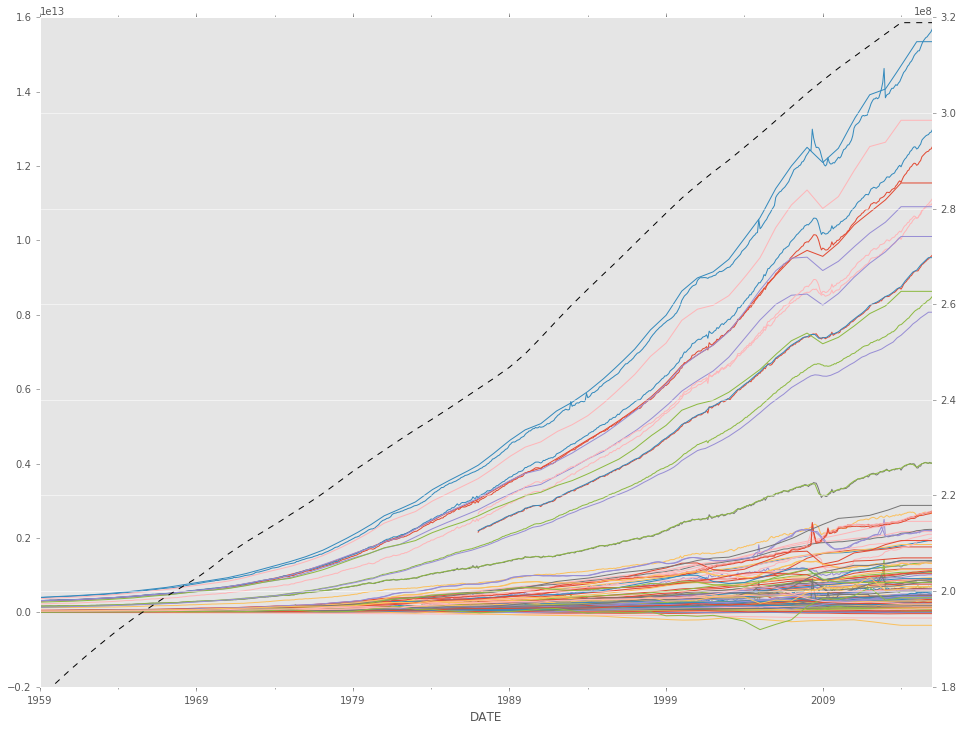

In [9]:
# Plot to check proper import
personal_data.plot(legend=False)
uspop_data.plot(legend=False, style='k--', secondary_y=True)


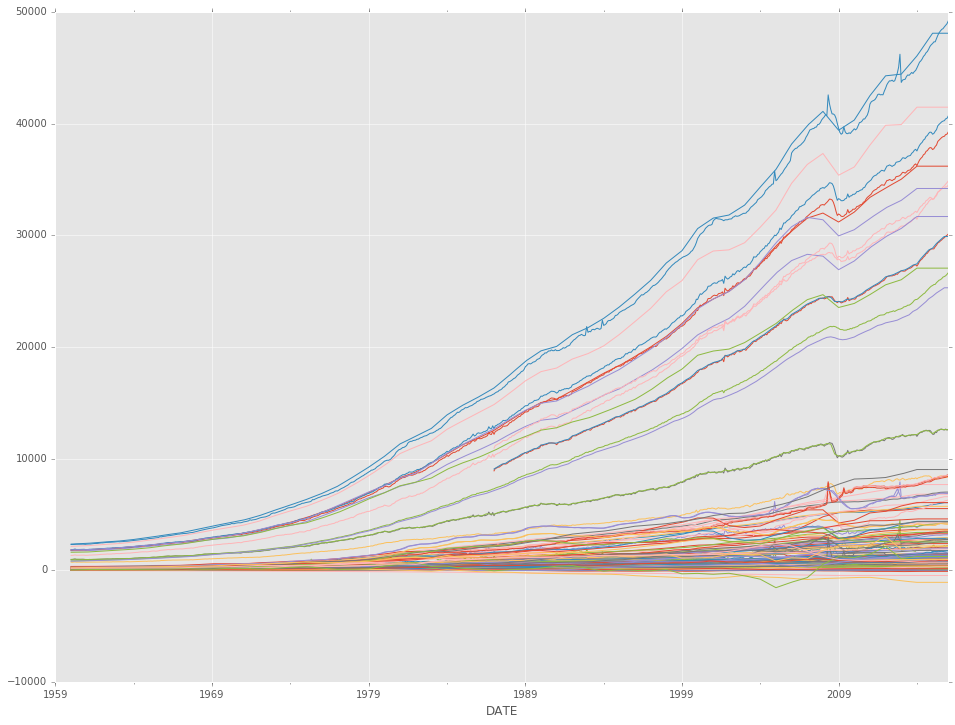

In [10]:
# Plot to check proper import
average_data.plot(legend=False)


In [11]:
# Collapse the heiarchy of categories to the last non Total level
categories = ['' for x in xrange(len(average_data.columns))]
for level in xrange(len(average_data.columns.levels)-1, -1, -1):
    for i, cat in enumerate(average_data.columns.get_level_values(level)):
        if cat != 'Total' and categories[i] == '':
            categories[i] = cat

# Replace multi index with collapsed categories
average_data.columns = categories

